# Movie project

## Imports

In [1]:
import os
from sklearn.impute import SimpleImputer
import ast
import json
import nltk
import string
import gensim
import pickle
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.svm import SVR
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn import preprocessing
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.linear_model import Ridge
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.stats.mstats import winsorize
import sklearn.feature_extraction.text as text
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from nltk.stem import SnowballStemmer,PorterStemmer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import  GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
import warnings
warnings.simplefilter("ignore")
# Download required resources (only needed once)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

## Data Gathering

In [4]:
movies = pd.read_csv("D:\movies-regression\movies-regression\movies-regression-dataset.csv");

In [5]:
credits = pd.read_csv("D:\movies-regression\movies-regression\movies-credit-students-train.csv");

In [6]:
credits.rename(columns = {'movie_id':'id'}, inplace = True)

In [7]:
data = movies.merge(credits,on='id')

In [8]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3033 entries, 0 to 3032
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                3033 non-null   int64  
 1   genres                3033 non-null   object 
 2   homepage              1125 non-null   object 
 3   id                    3033 non-null   int64  
 4   keywords              3033 non-null   object 
 5   original_language     3033 non-null   object 
 6   original_title        3033 non-null   object 
 7   overview              3032 non-null   object 
 8   viewercount           3033 non-null   float64
 9   production_companies  3033 non-null   object 
 10  production_countries  3033 non-null   object 
 11  release_date          3033 non-null   object 
 12  revenue               3033 non-null   int64  
 13  runtime               3032 non-null   float64
 14  spoken_languages      3033 non-null   object 
 15  status               

In [9]:
print("The number of unique values of 'id' column ",len(data['id'].unique()))

The number of unique values of 'id' column  3033


In [10]:
print("The number of unique values of 'tagline' column ",len(data['tagline'].unique()))

The number of unique values of 'tagline' column  2643


In [11]:
print("The unique values and its count of the status column :")
print(data['status'].value_counts())

The unique values and its count of the status column :
Released           3032
Post Production       1
Name: status, dtype: int64


In [12]:
date_mode = data['release_date'].mode()[0]
pickle.dump(date_mode, open("date_mode.pkl", "wb"))

In [13]:
data.drop(columns=['id','title_x','status'],inplace=True)#title_x ,title_y is the same so we droped one of them
data.rename(columns={'title_y':'title'},inplace=True)
data.drop(columns=['overview','homepage'],inplace=True)

In [14]:
data.dropna(subset=['runtime'],inplace=True)

In [15]:
data['day'] = pd.to_datetime(data['release_date']).dt.day # drop if it is not needed
data['month'] = pd.to_datetime(data['release_date']).dt.month
data['year'] = pd.to_datetime(data['release_date']).dt.year

In [16]:
data.drop(columns=['release_date'],inplace=True)

In [17]:
print(data.head())

     budget                                             genres  \
0  25000000  [{"id": 18, "name": "Drama"}, {"id": 10749, "n...   
1  38000000  [{"id": 878, "name": "Science Fiction"}, {"id"...   
2  20000000  [{"id": 36, "name": "History"}, {"id": 18, "na...   
3  23000000  [{"id": 18, "name": "Drama"}, {"id": 10749, "n...   
4  52000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   

                                            keywords original_language  \
0  [{"id": 4328, "name": "costume"}, {"id": 4528,...                en   
1  [{"id": 10988, "name": "based on tv series"}, ...                en   
2  [{"id": 237, "name": "gay"}, {"id": 582, "name...                en   
3  [{"id": 212, "name": "london england"}, {"id":...                en   
4  [{"id": 90, "name": "paris"}, {"id": 591, "nam...                en   

           original_title  viewercount  \
0       Mao's Last Dancer     1.876811   
1  Star Trek: Generations    14.779041   
2                    Milk    30.

## Data Split

In [18]:
data_input=data.drop(columns=['vote_average'])
data_output=data['vote_average']

In [19]:
x_train ,x_test ,y_train ,y_test = train_test_split(data_input ,data_output ,test_size = 0.2 ,random_state = 92)

In [20]:
print("Shape of train data is ",x_train.shape)
print("Shape of test data is ",x_test.shape)

Shape of train data is  (2425, 19)
Shape of test data is  (607, 19)


In [21]:
# Initialize WordNetLemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define a function to remove punctuation and stopwords and apply lemmatization
def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize words
    words = nltk.word_tokenize(text)
    # Remove stopwords and apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if not word.lower() in stop_words]
    # Join words into a sentence
    text = " ".join(words)
    return text

# Apply preprocessing on 'original_title' and 'title'
x_train['original_title'] = x_train['original_title'].apply(preprocess_text)
x_test['original_title'] = x_test['original_title'].apply(preprocess_text)
x_train['title'] = x_train['title'].apply(preprocess_text)
x_test['title'] = x_test['title'].apply(preprocess_text)

In [22]:
x_train['original_title'] = x_train['original_title'].str.lower()
x_train['title'] = x_train['title'].str.lower()
x_train['original_title_not_equal_title'] = x_train['original_title'] != x_train['title']
rows_not_equal = x_train[x_train['original_title_not_equal_title']]
print("The differnet rows between 'title' column and 'original_title' column in train data:")
print(rows_not_equal)

The differnet rows between 'title' column and 'original_title' column in train data:
        budget                                             genres  \
517   15000000  [{"id": 18, "name": "Drama"}, {"id": 28, "name...   
1671         0  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
976   26500000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
1228  11000000  [{"id": 27, "name": "Horror"}, {"id": 18, "nam...   
2336         0  [{"id": 14, "name": "Fantasy"}, {"id": 35, "na...   
...        ...                                                ...   
1914  26000000  [{"id": 18, "name": "Drama"}, {"id": 10749, "n...   
1756   4000000                      [{"id": 18, "name": "Drama"}]   
1348  12716953  [{"id": 80, "name": "Crime"}, {"id": 28, "name...   
2965       110  [{"id": 28, "name": "Action"}, {"id": 18, "nam...   
1506  19000000  [{"id": 16, "name": "Animation"}, {"id": 10751...   

                                               keywords original_language  \
517   [{"

In [23]:
x_train['original_title'] = np.where(x_train['original_title'] == x_train['title'], 1, 0)

In [24]:
x_test['original_title'] = x_test['original_title'].str.lower()
x_test['title'] = x_test['title'].str.lower()
x_test['original_title_not_equal_title'] = x_test['original_title'] != x_test['title']
rows_not_equal = x_test[x_test['original_title_not_equal_title']]
print("The differnet rows between 'title' column and 'original_title' column in test data:")
print(rows_not_equal)

The differnet rows between 'title' column and 'original_title' column in test data:
        budget                                             genres  \
1384  17000000  [{"id": 12, "name": "Adventure"}, {"id": 18, "...   
1638   5300000  [{"id": 18, "name": "Drama"}, {"id": 35, "name...   
612   24000000  [{"id": 14, "name": "Fantasy"}, {"id": 16, "na...   
1513  65000000  [{"id": 28, "name": "Action"}, {"id": 18, "nam...   
253   36000000  [{"id": 28, "name": "Action"}, {"id": 18, "nam...   
535          0  [{"id": 35, "name": "Comedy"}, {"id": 18, "nam...   
2201  18000000                    [{"id": 36, "name": "History"}]   
1285        10  [{"id": 18, "name": "Drama"}, {"id": 10749, "n...   
3009  15000000  [{"id": 16, "name": "Animation"}, {"id": 10751...   
1813         0  [{"id": 28, "name": "Action"}, {"id": 878, "na...   
2859  23000000  [{"id": 18, "name": "Drama"}, {"id": 28, "name...   
417          0  [{"id": 16, "name": "Animation"}, {"id": 10751...   
2042  33000000  [{"

In [25]:
x_test['original_title'] = np.where(x_test['original_title'] == x_test['title'], 1, 0)

In [26]:
print("Number of rows of 'original_title' colum in train data",x_train['original_title'].sum())
print("Number of rows of 'original_title' colum in test data",x_test['original_title'].sum())

Number of rows of 'original_title' colum in train data 2315
Number of rows of 'original_title' colum in test data 586


In [27]:
# This Column is similar to "Tiltle" Column with number of rows 2897 to the original data 3040 rows
x_train.drop(axis=1, columns=['original_title'], inplace=True)
x_test.drop(axis=1, columns=['original_title'], inplace=True)

In [28]:
x_train['tagline'] = x_train['tagline'].astype(str).fillna('')
x_test['tagline'] = x_test['tagline'].astype(str).fillna('')

In [29]:
# get sentiment value from title
# Define a function to get the sentiment score of a movie title using TextBlob
def get_sentiment_score(title):
    text_blob = TextBlob(title)
    return text_blob.sentiment.polarity

# Apply the function to the 'title' column of the DataFrame to get the sentiment scores
x_train['title'] = x_train['title'].apply(get_sentiment_score)
x_test['title'] = x_test['title'].apply(get_sentiment_score)

x_train['tagline'] = x_train['tagline'].apply(get_sentiment_score)
x_test['tagline'] = x_test['tagline'].apply(get_sentiment_score)

**Detect and Handling Outliers**

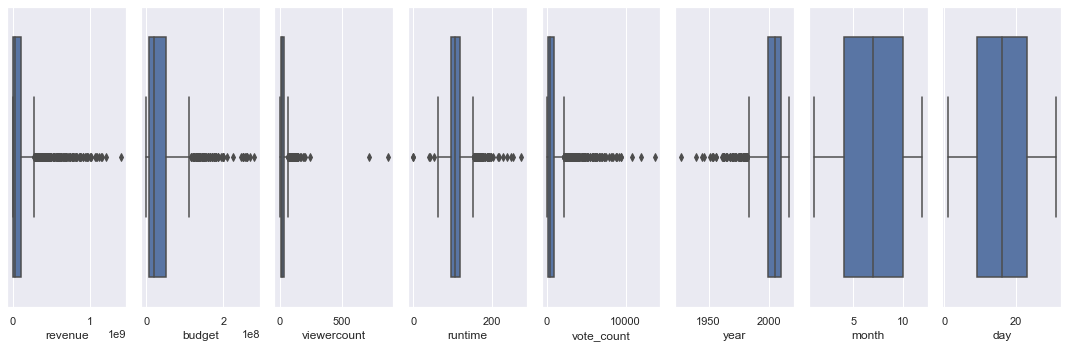

In [30]:
#checking outliers
sns.set()
fig, axs = plt.subplots(1,8, figsize = (15,5))
plt1 = sns.boxplot(x_train['revenue'], ax = axs[0])
plt2 = sns.boxplot(x_train['budget'], ax = axs[1])
plt3 = sns.boxplot(x_train['viewercount'], ax = axs[2])
plt4 = sns.boxplot(x_train['runtime'], ax = axs[3])
plt5 = sns.boxplot(x_train['vote_count'], ax = axs[4])
plt6 = sns.boxplot(x_train['year'], ax = axs[5])
plt7 = sns.boxplot(x_train['month'], ax = axs[6])
plt8 = sns.boxplot(x_train['day'], ax = axs[7])

plt.tight_layout()

In [31]:
x_test = x_test.reset_index(drop=True)

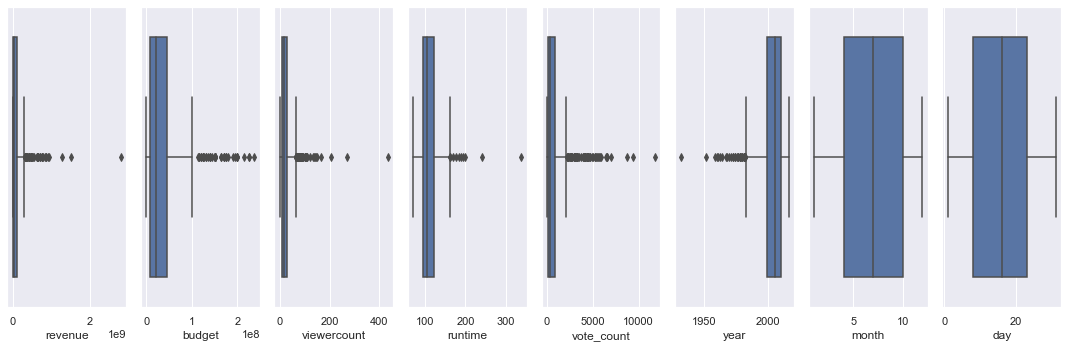

In [32]:
#checking outliers
sns.set()
fig, axs = plt.subplots(1,8, figsize = (15,5))
plt1 = sns.boxplot(x_test['revenue'], ax = axs[0])
plt2 = sns.boxplot(x_test['budget'], ax = axs[1])
plt3 = sns.boxplot(x_test['viewercount'], ax = axs[2])
plt4 = sns.boxplot(x_test['runtime'], ax = axs[3])
plt5 = sns.boxplot(x_test['vote_count'], ax = axs[4])
plt6 = sns.boxplot(x_test['year'], ax = axs[5])
plt7 = sns.boxplot(x_test['month'], ax = axs[6])
plt8 = sns.boxplot(x_test['day'], ax = axs[7])

plt.tight_layout()

In [33]:
def replace_outlier(col):
    
    limits=[]
    col_q1=x_train[col].quantile(0.25)
    col_q3=x_train[col].quantile(0.75)
    col_iqr=col_q3-col_q1

    col_upper_limit=col_q3+(1.5*col_iqr)
    col_lower_limit=col_q1-(1.5*col_iqr)

    limits.append(col_upper_limit)
    limits.append(col_lower_limit)

    x_train.loc[x_train[col] > col_upper_limit,col]= col_upper_limit
    x_train.loc[x_train[col] < col_lower_limit,col]= col_lower_limit
    return limits

def replace_test_outlier(col,limits):
    x_test.loc[x_test[col] > limits[0],col]=limits[0]
    x_test.loc[x_test[col] < limits[1],col]=limits[1]

In [34]:
limit_values = []

In [35]:
outliers_column=['revenue','budget','runtime','vote_count','viewercount','year']
for col in outliers_column:
    limits=replace_outlier(col)
    limit_values.append(limits)
    replace_test_outlier(col,limits)

In [36]:
pickle.dump(limit_values, open("limit_values.pkl", "wb"))

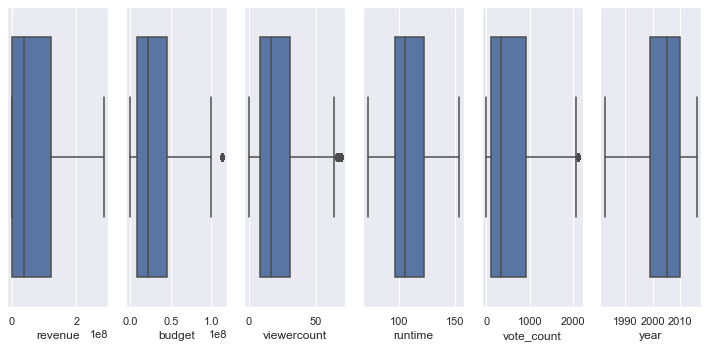

In [37]:
#checking outliers testtttttttttt
sns.set()
fig, axs = plt.subplots(1,6, figsize = (10,5))
plt7 = sns.boxplot(x_test['revenue'], ax = axs[0])
plt2 = sns.boxplot(x_test['budget'], ax = axs[1])
plt3 = sns.boxplot(x_test['viewercount'], ax = axs[2])
plt4 = sns.boxplot(x_test['runtime'], ax = axs[3])
plt5 = sns.boxplot(x_test['vote_count'], ax = axs[4])
plt6 = sns.boxplot(x_test['year'], ax = axs[5])

plt.tight_layout()

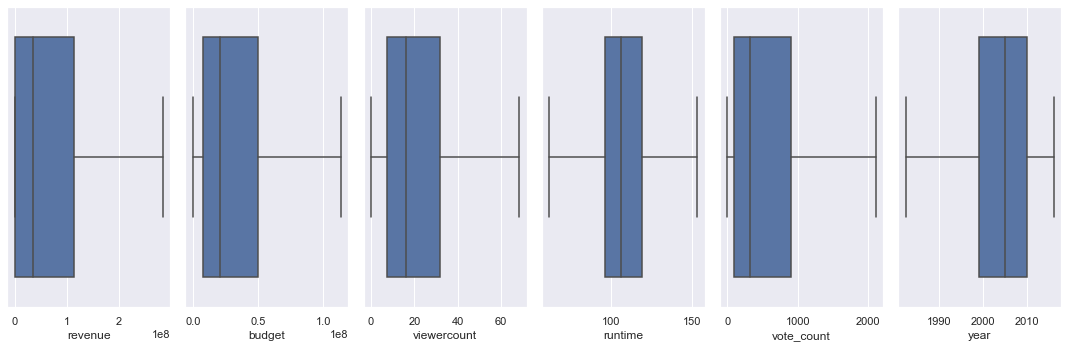

In [38]:
#checking outliers
sns.set()
fig, axs = plt.subplots(1,6, figsize = (15,5))
plt1 = sns.boxplot(x_train['revenue'], ax = axs[0])
plt2 = sns.boxplot(x_train['budget'], ax = axs[1])
plt3 = sns.boxplot(x_train['viewercount'], ax = axs[2])
plt4 = sns.boxplot(x_train['runtime'], ax = axs[3])
plt5 = sns.boxplot(x_train['vote_count'], ax = axs[4])
plt6 = sns.boxplot(x_train['year'], ax = axs[5])
plt.tight_layout()

**Handling Missing Values**

In [39]:
budget_mean=x_train[x_train["budget"] > 0].budget.describe().mean()
runtime_mean=x_train[x_train["runtime"] > 0].runtime.describe().mean()

In [40]:
pickle.dump(budget_mean, open("budget_mean.pkl", "wb"))
pickle.dump(runtime_mean, open("runtime_mean.pkl", "wb"))

In [41]:
x_train['budget'].replace(0,budget_mean,inplace=True)
x_train['runtime'].replace(0,runtime_mean,inplace=True)

x_test['budget'].replace(0,budget_mean,inplace=True)
x_test['runtime'].replace(0,runtime_mean,inplace=True)

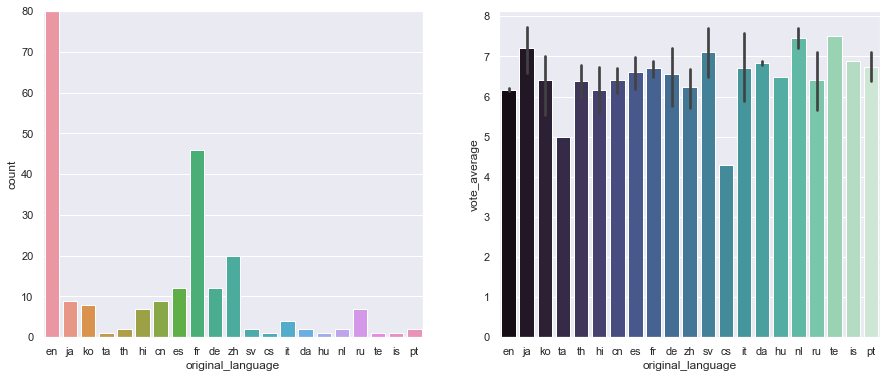

In [42]:
fig, axs = plt.subplots(1,2, figsize = (15,6))
plt1 = sns.countplot(x='original_language',data=data, ax = axs[0])
plt1.set_ylim([0, 80])
plt2 = sns.barplot(x='original_language',y='vote_average',data=data, ax = axs[1],palette="mako")
plt.show()

**Preprocessing the "original_language" Column using Label Encoder**

In [43]:
print("unique values of 'original_language' column is",x_train['original_language'].unique())

unique values of 'original_language' column is ['zh' 'en' 'fr' 'ja' 'ko' 'de' 'hi' 'ru' 'es' 'sv' 'nl' 'th' 'hu' 'cn'
 'it' 'da' 'pt' 'cs' 'ta']


In [44]:
OL_mode = x_train['original_language'].mode()[0]

In [45]:
pickle.dump(OL_mode, open("OL_mode.pkl", "wb"))

In [46]:
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
oe.fit(x_train[['original_language']])

# save the model to disk
# Save the encoder to a file using pickle
with open('encoder.pkl', 'wb') as f:
    pickle.dump(oe, f)

x_train['original_language'] = oe.transform(x_train[['original_language']])
x_test['original_language'] = oe.transform(x_test[['original_language']])

**Extract names from columns**

In [47]:
json_cols = ['genres', 'keywords', 'production_companies', 'spoken_languages', 'production_countries']

def extract_keywords(x):
    L=[]
    counter = 0
    for i in ast.literal_eval(x):
        if counter < 3:
            L.append(i['name'])
        counter+=1
    return L
for col in json_cols:
    x_train[col]=x_train[col].apply(extract_keywords)
for col in json_cols:
    x_test[col]=x_test[col].apply(extract_keywords)

def convert3(text):
    L = []
    counter = 0
    for i in ast.literal_eval(text):
        if counter < 3:
            L.append(i['name'])
        counter+=1
    return L

x_train['cast']=x_train['cast'].apply(convert3)
x_test['cast']=x_test['cast'].apply(convert3)

def fetch_director(text):
    L = []
    for i in ast.literal_eval(text):
        if i['job'] == 'Director':
            L.append(i['name'])      
    return L
    
x_train['crew']=x_train['crew'].apply(fetch_director)
x_test['crew']=x_test['crew'].apply(fetch_director)

In [48]:
class Our_OneHotEncoder:
    data = set()
    
    def __init__(self):
        self.data.clear()
    
    def fit_freq(self, freq_set):
        # adding items to data field
        self.data = freq_set
    
    def fit(self, df, column_name):
        # adding items to data field
        for lst in df[column_name]:
            for element in lst:
                self.data.add(element)

    def transform(self, df, column_name):
        data_lst = list(self.data)
        
        #Initializing the one-hot columns
        for col in data_lst:
            df[col] = np.zeros(df.shape[0], dtype=int)
        
        # One-Hot Encoding
        for i, row in df.iterrows():
            for element in row[column_name]:
                if element in data_lst:
                    df.loc[i, element] = 1
        df.drop(columns=[column_name],inplace=True)    

oneHotColumns=['genres', 'production_countries']
saved_fitted_data = []
for col in oneHotColumns:
    encoder=Our_OneHotEncoder()
    encoder.fit(x_train,col)
    saved_fitted_data.append(list(encoder.data))
    encoder.transform(x_train,col)
    encoder.transform(x_test,col)

In [49]:
pickle.dump(saved_fitted_data, open("saved_fitted_data.pkl", "wb"))

In [50]:
word2vectorColumns=['keywords','cast','crew', 'spoken_languages', 'production_companies']
def word2vectorFunction(data,col):
    model1 = gensim.models.Word2Vec(data[col], min_count = 1)
    X = []
    for keyword in data[col]:
        feature_vec = np.zeros((100,))
        for word in keyword:
            if word in model1.wv.key_to_index:
                feature_vec += model1.wv[word]
        X.append(feature_vec)
    data[col] = X
for col in word2vectorColumns:
    word2vectorFunction(x_train,col)
    word2vectorFunction(x_test,col)

**Calculating mean**

In [51]:
import statistics
from statistics import mean
columns = ['keywords' ,'cast', 'crew', 'spoken_languages', 'production_companies']   

def calculate_mean(df, col):
    for i, row in df.iterrows():
        df.loc[i, col] = mean(df.loc[i, col])
        
for col in columns:
    calculate_mean(x_train, col)
    calculate_mean(x_test, col)

In [52]:
vote_count_med = x_train['vote_count'].median()

In [53]:
viewer_count_med = x_train['viewercount'].median()

In [54]:
revnue_med = x_train['revenue'].median()

In [55]:
pickle.dump(vote_count_med, open("vote_count_med.pkl", "wb"))
pickle.dump(viewer_count_med, open("viewer_count_med.pkl", "wb"))
pickle.dump(revnue_med, open("revnue_med.pkl", "wb"))

**Scaling**

In [56]:
cols=['budget','viewercount','revenue','runtime','vote_count','year','month','day']
scaler = StandardScaler()
scaler.fit(x_train[cols])
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
x_train[cols]=scaler.transform(x_train[cols])
x_test[cols]=scaler.transform(x_test[cols])
print(x_train.head())

        budget  keywords  original_language  viewercount production_companies  \
517  -0.774679 -0.000071               18.0    -0.887840             0.000925   
1964  2.530670   0.00131                4.0     2.463698             0.000596   
742   0.932388  -0.00065                4.0     0.205344             0.001342   
549  -0.607319 -0.001037                4.0    -0.430425               0.0005   
2277 -1.059190    -0.001                4.0     0.371776             0.000154   

       revenue   runtime spoken_languages  tagline  vote_count  ...  Denmark  \
517  -0.821933  0.568058         0.000347     -0.2   -0.815948  ...        0   
1964  2.258566  1.186345         0.000407      0.0    2.208655  ...        0   
742   1.483069  0.174604         0.000407      0.0   -0.023069  ...        0   
549  -0.397146 -0.387475        -0.000711     -0.2   -0.494072  ...        0   
2277 -0.552875 -0.949553         0.000407      0.0    0.068474  ...        0   

     Hungary Panama  Brazil  Cze

In [57]:
x_train.drop(columns=['title','tagline','original_title_not_equal_title'],inplace=True)
x_test.drop(columns=['title','tagline','original_title_not_equal_title'],inplace=True)

## Feature Selection

### Pearson's Correlation

In [58]:
from sklearn.feature_selection import SelectKBest, f_regression

# Calculate the Pearson correlation coefficients between each feature and the target variable
corr_matrix = x_train.corrwith(y_train, method='pearson').abs()

# Sort the features in descending order of correlation with the target variable
sorted_corr = corr_matrix.sort_values(ascending=False)

# Set the maximum number of columns and rows to display to None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Print the sorted correlations
print("the sorted correlations :")

the sorted correlations :


In [59]:
len(sorted_corr)

87

### K-Best

In [60]:
# Use SelectKBest to select the top k features based on the f_regression test
k = 85
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(x_train, y_train)

# Get the indices of the selected features
selected_features = x_train.columns[selector.get_support()]

# Print the selected features
print('Selected features of K-best :', selected_features)

Selected features of K-best : Index(['budget', 'keywords', 'original_language', 'viewercount',
       'production_companies', 'revenue', 'runtime', 'spoken_languages',
       'vote_count', 'cast', 'day', 'month', 'year', 'Animation', 'Adventure',
       'Music', 'Western', 'Fantasy', 'Romance', 'Comedy', 'Mystery',
       'Foreign', 'Science Fiction', 'Horror', 'Action', 'Drama', 'War',
       'Documentary', 'Family', 'History', 'Crime', 'Thriller', 'Taiwan',
       'India', 'Libyan Arab Jamahiriya', 'Bosnia and Herzegovina', 'Israel',
       'Sweden', 'Netherlands', 'Iceland', 'Malta', 'South Korea', 'Monaco',
       'Kazakhstan', 'Chile', 'South Africa', 'Germany', 'Austria', 'Belgium',
       'Aruba', 'Singapore', 'Poland', 'Italy', 'France', 'Spain', 'Japan',
       'Jamaica', 'Pakistan', 'Malaysia', 'Norway', 'United Kingdom',
       'Switzerland', 'Finland', 'Ireland', 'Bahamas', 'Argentina',
       'Luxembourg', 'Bulgaria', 'Mexico', 'Ukraine', 'Russia', 'Romania',
       'Fiji'

### Selecting Suitable Columns

In [61]:
x_train = x_train[sorted_corr[:-17].keys()]

x_test = x_test[sorted_corr[:-17].keys()]

In [62]:
pickle.dump(sorted_corr, open("sorted_corr.pkl", "wb"))

In [63]:
print("shape of train data after selection is ",x_train.shape)

shape of train data after selection is  (2425, 70)


In [64]:
print("shape of test data after selection is ",x_test.shape)

shape of test data after selection is  (607, 70)


In [65]:
def model_plot(name,y_pred):
    # Plot the predicted values against the true values
    plt.scatter(y_test, y_pred)

    # Add a title and axis labels
    plt.title(f"{name}")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")

    # Add a diagonal line to indicate perfect fit
    plt.plot([y_test.min(), y_test.max()+2], [y_test.min(), y_test.max()+2], 'k--', lw=4)

    # Set the axis limits
    plt.xlim(y_test.min()-0.1, y_test.max()+2)
    plt.ylim(y_test.min()-0.1, y_test.max()+2)

    # Show the plot
    plt.show()

## Regression Models

### SVR

In [66]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define the model
svr = SVR()

# Define the hyperparameters to tune
params = {'kernel': ['rbf'],
          'C': [1.9],
          'gamma': ['scale']}

# Define the GridSearchCV object
grid_svr = GridSearchCV(svr, param_grid=params, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_svr.fit(x_train, y_train)

with open('svr.pkl', 'wb') as f:
    pickle.dump(grid_svr, f)

# Print the best hyperparameters
print(grid_svr.best_params_)

# Make predictions on the test set
y_pred = grid_svr.predict(x_test)

# Evaluate the model
print("MSE of SVR : ", mean_squared_error(y_test, y_pred))
print("RMSE of SVR : ", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"R^2 of SVR : {(r2_score(y_test, y_pred)):.2f}")

{'C': 1.9, 'gamma': 'scale', 'kernel': 'rbf'}
MSE of SVR :  0.3411588278740065
RMSE of SVR :  0.5840880309285634
R^2 of SVR : 0.60


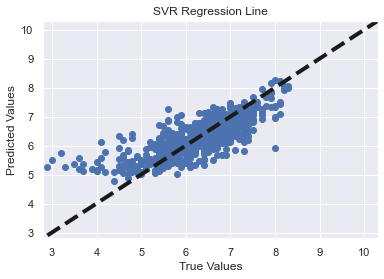

In [67]:
model_plot("SVR Regression Line",y_pred)

### Ridge Regression

In [68]:
# Define the model with fixed random seed
ridge = Ridge(random_state=84)

# Define the hyperparameters to tune
params = {'alpha': [10.6],
          'solver': ['sparse_cg']}

# Define the GridSearchCV object with fixed random seed
grid_ridge = GridSearchCV(ridge, param_grid=params, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_ridge.fit(x_train, y_train)

with open('ridge.pkl', 'wb') as f:
    pickle.dump(grid_ridge, f)
    
# Print the best hyperparameters
print(grid_ridge.best_params_)

# Make predictions on the test set
y_pred = grid_ridge.predict(x_test)

# Evaluate the model
print("MSE of Ridge Regression: ", mean_squared_error(y_test, y_pred))
print("RMSE of Ridge Regression: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"R^2 of Ridge Regression: {(r2_score(y_test, y_pred)):.2f}")

{'alpha': 10.6, 'solver': 'sparse_cg'}
MSE of Ridge Regression:  0.3752106355142113
RMSE of Ridge Regression:  0.6125443947292403
R^2 of Ridge Regression: 0.56


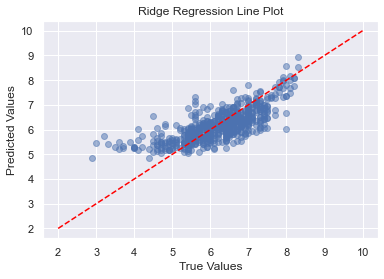

In [69]:
# Create a scatter plot of true vs predicted values
plt.scatter(y_test, y_pred, alpha=0.5)

# Add a diagonal line to indicate perfect fit
plt.plot(np.linspace(2, 10), np.linspace(2, 10), color='red', linestyle='--')

# Add axis labels and a title
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression Line Plot")

# Show the plot
plt.show()

### Principal Components Regression

In [70]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Perform PCA on the training data
pca = PCA(n_components=31)
pca.fit(x_train)

with open('pca.pkl', 'wb') as f:
    pickle.dump(pca, f)
    
X_train_pca = pca.transform(x_train)

# Train a linear regression model on the PCA-transformed data
model = LinearRegression()
model.fit(X_train_pca, y_train)

with open('linear_pca.pkl', 'wb') as f:
    pickle.dump(model, f)
    
# Transform the test data using the same PCA transformation
X_test_pca = pca.transform(x_test)

# Make predictions on the test data
y_pred = model.predict(X_test_pca)

# Evaluate the model using R-squared
score = r2_score(y_test, y_pred)

# Evaluate the model
print("MSE of Principal Components Regression: ", mean_squared_error(y_test, y_pred))
print("RMSE of Principal Components Regression: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"R-squared score of Principal Components Regression: {score:.2f}")

MSE of Principal Components Regression:  0.37377128447677904
RMSE of Principal Components Regression:  0.6113683705236794
R-squared score of Principal Components Regression: 0.56


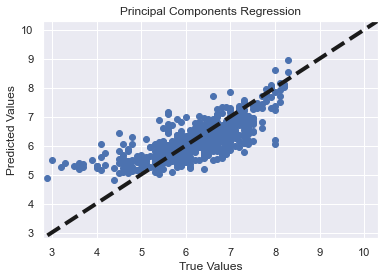

In [71]:
model_plot("Principal Components Regression",y_pred)

### Elastic Net Regression

In [72]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score

# Train an Elastic Net regression model
model = ElasticNet(alpha=0.01, l1_ratio=0.0)
model.fit(x_train, y_train)
with open('elastic.pkl', 'wb') as f:
    pickle.dump(model, f)

# Make predictions on the test data
y_pred = model.predict(x_test)

# Evaluate the model using R-squared
score = r2_score(y_test, y_pred)
# Evaluate the model
print("MSE of Elastic Net Regression: ", mean_squared_error(y_test, y_pred))
print("RMSE of Elastic Net Regression: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"R-squared score of Elastic Net Regression: {score:.2f}")

MSE of Elastic Net Regression:  0.37620900674254976
RMSE of Elastic Net Regression:  0.6133587912001831
R-squared score of Elastic Net Regression: 0.56


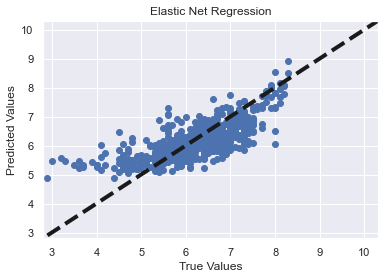

In [73]:
model_plot("Elastic Net Regression",y_pred)

### Partial Least Squares Regression

In [74]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score

# Train a PLS regression model
model = PLSRegression(n_components=5)
model.fit(x_train, y_train)

with open('pls.pkl', 'wb') as f:
    pickle.dump(model, f)
# Make predictions on the test data
y_pred = model.predict(x_test)

# Evaluate the model using R-squared
score = r2_score(y_test, y_pred)
# Evaluate the model
print("MSE of Partial Least Squares Regression: ", mean_squared_error(y_test, y_pred))
print("RMSE of Partial Least Squares Regression: ", np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"R-squared score of Partial Least Squares Regression: {score:.2f}")

MSE of Partial Least Squares Regression:  0.3793475949934245
RMSE of Partial Least Squares Regression:  0.6159120026378967
R-squared score of Partial Least Squares Regression: 0.55


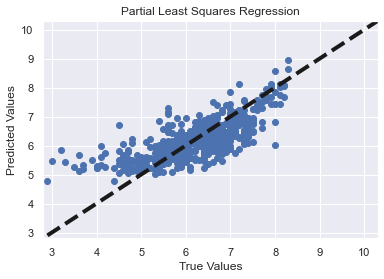

In [75]:
model_plot("Partial Least Squares Regression",y_pred)

### Polynomial Regression

In [76]:
#Create polynomial features
polynomial_features = PolynomialFeatures(degree=1)

polynomial_features.fit(x_train)

with open('poly_feature.pkl', 'wb') as f:
    pickle.dump(polynomial_features, f)

x_poly = polynomial_features.transform(x_train)


# Create and fit the polynomial regression model
model = LinearRegression().fit(x_poly, y_train)

with open('poly.pkl', 'wb') as f:
    pickle.dump(model, f)

# Predict y values using the model
y_pred = model.predict(polynomial_features.transform(x_test))

# Evaluate performance of model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'MSE of poynoimal regression: {mse:.2f}')
print(f'RMSE of poynoimal regression: {rmse:.2f}')
print(f'R-squared of poynoimal regression: {r2:.2f}')

MSE of poynoimal regression: 0.38
RMSE of poynoimal regression: 0.62
R-squared of poynoimal regression: 0.55


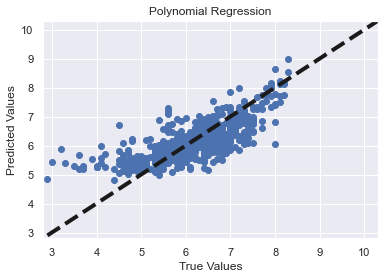

In [77]:
model_plot("Polynomial Regression",y_pred)